# Algorithm Chains and Pipelines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn
sklearn.set_config(print_changed_only=True)

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)
# rescale training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
svm.score(X_test_scaled, y_test)

0.972027972027972

### Building Pipelines

In [3]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [4]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [5]:
pipe.score(X_test, y_test)

0.972027972027972

### Using Pipelines in Grid-searches

In [6]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [7]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid=param_grid)
grid.fit(X_train, y_train)
print("best cross-validation accuracy:", grid.best_score_)
print("test set score: ", grid.score(X_test, y_test))
print("best parameters: ", grid.best_params_)

best cross-validation accuracy: 0.9812311901504789
test set score:  0.972027972027972
best parameters:  {'svm__C': 1, 'svm__gamma': 1}


# Not using Pipelines vs feature selection

In [8]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [9]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression,
                          percentile=5)
select.fit(X, y)
X_selected = select.transform(X)
print(X_selected.shape)

(100, 500)


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
np.mean(cross_val_score(Ridge(), X_selected, y))

0.9057953065239822

In [11]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                 ("ridge", Ridge())])
np.mean(cross_val_score(pipe, X, y))

-0.2465542238495281

### The General Pipeline Interface

In [12]:
def fit(self, X, y):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = step[1].fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [13]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # predict using the last step
    return self.steps[-1][1].predict(X_transformed)

### Convenient Pipeline creation with ``make_pipeline``

In [14]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [15]:
pipe_short.steps

[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2),
                     StandardScaler())
pipe.steps

[('standardscaler-1', StandardScaler()),
 ('pca', PCA(n_components=2)),
 ('standardscaler-2', StandardScaler())]

#### Accessing step attributes

In [17]:
# fit the pipeline defined above to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps.pca.components_
print(components.shape)

(2, 30)


In [18]:
pipe['pca']

PCA(n_components=2)

In [19]:
pipe[0]

StandardScaler()

In [20]:
pipe[1]

PCA(n_components=2)

In [21]:
pipe[:2]

Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=2))])

#### Accessing attributes in grid-searched pipeline.

In [22]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [23]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [25]:
print(grid.best_estimator_)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [26]:
print(grid.best_estimator_.named_steps.logisticregression)
print(grid.best_estimator_['logisticregression'])

LogisticRegression(C=1, max_iter=1000)
LogisticRegression(C=1, max_iter=1000)


In [27]:
print(grid.best_estimator_.named_steps.logisticregression.coef_)

[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


In [28]:
print(grid.best_estimator_['logisticregression'].coef_)

[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


### Grid-searching preprocessing steps and model parameters

In [29]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(
    diabetes.data, diabetes.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [30]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [31]:
grid = GridSearchCV(pipe, param_grid=param_grid,
                    n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

In [32]:
res = pd.DataFrame(grid.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009374,2.238970e-03,0.000798,0.000399,1,0.001,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.433550,0.486062,0.514033,...,0.512238,0.049383,5,0.579986,0.565378,0.556566,0.547340,0.547173,0.559289,0.012349
1,0.007978,8.919101e-04,0.001197,0.000399,1,0.01,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.433578,0.486053,0.514045,...,0.512254,0.049385,4,0.579986,0.565378,0.556566,0.547340,0.547173,0.559289,0.012349
2,0.012566,6.752189e-03,0.001595,0.000489,1,0.1,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.433841,0.485966,0.514161,...,0.512406,0.049413,3,0.579982,0.565377,0.556563,0.547339,0.547166,0.559285,0.012349
3,0.003186,1.924576e-03,0.000598,0.000489,1,1,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.435508,0.485451,0.514905,...,0.513376,0.049622,2,0.579731,0.565309,0.556384,0.547307,0.546763,0.559099,0.012352
4,0.001994,7.599534e-07,0.000598,0.000488,1,10,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.441858,0.487365,0.516466,...,0.515968,0.048215,1,0.577828,0.564338,0.554608,0.546770,0.543759,0.557461,0.012428


In [33]:
res = pd.pivot_table(res, index=['param_polynomialfeatures__degree', 'param_ridge__alpha'],
               values=['mean_train_score', 'mean_test_score'])

In [34]:
res['mean_train_score'].unstack()

param_ridge__alpha,0.001,0.010,0.100,1.000,10.000,100.000
param_polynomialfeatures__degree,,,,,,
1,0.559289,0.559289,0.559285,0.559099,0.557461,0.536270
2,0.666707,0.666268,0.664697,0.661747,0.650237,0.605903
3,0.974622,0.958083,0.927772,0.883468,0.823504,0.719794


In [35]:
res['mean_test_score'].unstack()

param_ridge__alpha,0.001,0.010,0.100,1.000,10.000,100.000
param_polynomialfeatures__degree,,,,,,
1,0.512238,0.512254,0.512406,0.513376,0.515968,0.507934
2,0.374003,0.379897,0.392917,0.428173,0.471838,0.492605
3,-51.023088,-16.452330,-5.166146,-1.194386,0.060621,0.315993


In [36]:
print(grid.best_params_)

{'polynomialfeatures__degree': 1, 'ridge__alpha': 10}


In [37]:
grid.best_estimator_['polynomialfeatures'].get_feature_names(diabetes.feature_names)

['1', 'age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [38]:
grid.score(X_test, y_test)

0.3580342762914789

In [39]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold

In [40]:
pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge())])

param_grid = {'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
              'regressor': [Ridge(), Lasso()],
              'regressor__alpha': np.logspace(-3, 3, 7)}

grid = GridSearchCV(pipe, param_grid,
                    cv=RepeatedKFold(n_splits=10, n_repeats=10))
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.3556784125736949

In [41]:
grid.best_score_

0.5041191056200575

In [42]:
grid.best_params_

{'regressor': Lasso(), 'regressor__alpha': 1.0, 'scaler': StandardScaler()}

In [43]:
from sklearn.tree import DecisionTreeRegressor
param_grid = [{'regressor': [DecisionTreeRegressor()],
               'regressor__max_depth': [2, 3, 4]},
              {'regressor': [Ridge()],
               'regressor__alpha': [0.1, 1]}
             ]

# More on ColumnTransformer

In [44]:
from sklearn.compose import make_column_transformer, ColumnTransformer
bike = pd.read_csv("data/bike_day_raw.csv")
bike.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [45]:
bike.dtypes

season          int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [46]:
bike_data = bike.drop("cnt", axis=1)
cat_features = bike.columns[:6]
cat_features

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], dtype='object')

In [47]:
from sklearn.preprocessing import OneHotEncoder
ct = make_column_transformer((OneHotEncoder(sparse=False), cat_features),
                             remainder=StandardScaler())
ct.transformers

[('onehotencoder',
  OneHotEncoder(sparse=False),
  Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], dtype='object'))]

In [48]:
ColumnTransformer([('ohe', OneHotEncoder(sparse=False), cat_features)],
                  remainder=StandardScaler())

ColumnTransformer([('ohe', OneHotEncoder(sparse=False), cat_features),
                   ('scaler', StandardScaler(), [6, 7, 8, 9])])

ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse=False),
                                 Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], dtype='object')),
                                ('scaler', StandardScaler(), [6, 7, 8, 9])])

In [49]:
ct.fit(bike_data)

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(sparse=False),
                                 Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], dtype='object'))])

In [50]:
bike_data.shape

(731, 10)

In [51]:
ct.transform(bike_data).shape

(731, 34)

In [52]:
ct.transform(bike_data)

array([[ 1.        ,  0.        ,  0.        , ..., -0.67994602,
         1.25017133, -0.38789169],
       [ 1.        ,  0.        ,  0.        , ..., -0.74065231,
         0.47911298,  0.74960172],
       [ 1.        ,  0.        ,  0.        , ..., -1.749767  ,
        -1.33927398,  0.74663186],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -1.42434419,
         0.87839173, -0.85355213],
       [ 1.        ,  0.        ,  0.        , ..., -1.49004895,
        -1.01566357,  2.06944426],
       [ 1.        ,  0.        ,  0.        , ..., -1.54048197,
        -0.35406086, -0.46020122]])

In [53]:
ct = make_column_transformer((OneHotEncoder(sparse=False), cat_features),
                             remainder=StandardScaler())
ohe_pipe = make_pipeline(ct, Ridge())

In [54]:
X_train, X_test, y_train, y_test = train_test_split(bike_data, bike.cnt, random_state=42)

In [55]:
cross_val_score(ohe_pipe, X_train, y_train)

array([0.52406232, 0.5348351 , 0.60879866, 0.40745233, 0.55003895])

In [56]:
from sklearn.preprocessing import PowerTransformer

ct = make_column_transformer((OneHotEncoder(sparse=False), cat_features))
ohe_pipe = make_pipeline(ct, Ridge())

param_grid = {'columntransformer__remainder':
              [StandardScaler(), PowerTransformer(method='yeo-johnson')],
              'ridge__alpha': np.logspace(-3, 2, 6)}
grid = GridSearchCV(ohe_pipe, param_grid)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.5446847016583232

In [57]:
grid.best_params_

{'columntransformer__remainder': StandardScaler(), 'ridge__alpha': 10.0}

In [58]:
res = pd.DataFrame(grid.cv_results_)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__remainder,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006383,0.000489,0.003590,4.888307e-04,StandardScaler(),0.001,{'columntransformer__remainder': StandardScale...,0.523292,0.530999,0.610672,0.401703,0.546912,0.522716,0.067874,6
1,0.005585,0.000489,0.003191,3.990174e-04,StandardScaler(),0.01,{'columntransformer__remainder': StandardScale...,0.523306,0.531043,0.610661,0.401770,0.546942,0.522744,0.067851,5
2,0.005585,0.000489,0.003191,3.989221e-04,StandardScaler(),0.1,{'columntransformer__remainder': StandardScale...,0.523435,0.531467,0.610539,0.402414,0.547236,0.523018,0.067621,4
3,0.005784,0.000399,0.003192,3.990173e-04,StandardScaler(),1,{'columntransformer__remainder': StandardScale...,0.524062,0.534835,0.608799,0.407452,0.550039,0.525037,0.065672,2
4,0.005789,0.000402,0.002987,9.968748e-06,StandardScaler(),10,{'columntransformer__remainder': StandardScale...,0.515989,0.550924,0.594814,0.423947,0.566987,0.530532,0.059074,1
5,0.005549,0.000514,0.003002,1.240638e-05,StandardScaler(),100,{'columntransformer__remainder': StandardScale...,0.451963,0.547740,0.538225,0.421852,0.553704,0.502697,0.054777,11
6,0.010572,0.000798,0.003590,4.884220e-04,PowerTransformer(),0.001,{'columntransformer__remainder': PowerTransfor...,0.516199,0.532617,0.595314,0.393089,0.541294,0.515703,0.066803,10
7,0.010372,0.000798,0.002992,2.780415e-07,PowerTransformer(),0.01,{'columntransformer__remainder': PowerTransfor...,0.516204,0.532670,0.595368,0.393087,0.541340,0.515734,0.066823,9
8,0.009774,0.000747,0.003590,4.888308e-04,PowerTransformer(),0.1,{'columntransformer__remainder': PowerTransfor...,0.516240,0.533174,0.595828,0.393100,0.541763,0.516021,0.066986,8
9,0.011968,0.000631,0.003391,4.887335e-04,PowerTransformer(),1,{'columntransformer__remainder': PowerTransfor...,0.516252,0.536836,0.596867,0.394672,0.544733,0.517872,0.067085,7


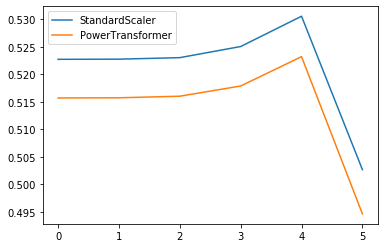

In [59]:
plt.plot(res.mean_test_score[:6].values, label="StandardScaler")
plt.plot(res.mean_test_score[6:].values, label="PowerTransformer")
plt.legend()

# Exercise

Load the adult dataset. Create a pipline using the ColumnTransformer, OneHotEncoder, Scaling, and polynomial features and a linear classifier.

Search over the best options for the polynomial features together with the regularization of a linear model.

In [60]:
pd.read_csv("data/adult.csv", index_col=0).head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# use OneHotEncoder(handle_unknown='ignore') to ignore new categories in test set.